# Pricing test

I am going to look at the data and understand the effect of increasing the software price from 39 to 59 dollars. 

## Read in the data

In [1]:
import pandas as pd

In [2]:
results = pd.read_csv("./data/test_results.csv",index_col=False)

user_info = pd.read_csv("./data/user_table.csv")

In [3]:
results.head()

,Unnamed: 0,user_id,timestamp,source,device,operative_system,test,price,converted
0,0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39.0,0
1,1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39.0,0
2,2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39.0,0
3,3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59.0,0
4,4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39.0,0


In [4]:
results = results.drop(results.columns[0], axis = 1)

In [5]:
results.head()

,user_id,timestamp,source,device,operative_system,test,price,converted
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39.0,0
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39.0,0
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39.0,0
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59.0,0
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39.0,0


In [6]:
user_info.head()

,user_id,city,country,lat,long
0,510335,Peabody,USA,42.53,-70.97
1,89568,Reno,USA,39.54,-119.82
2,434134,Rialto,USA,34.11,-117.39
3,289769,Carson City,USA,39.15,-119.74
4,939586,Chicago,USA,41.84,-87.68



## Missing values
we need to look at the amount of missing values for two data frames. 

In [7]:
results.isnull().sum()

user_id                 0
timestamp             334
source                312
device                  0
operative_system    20339
test                    0
price                   0
converted               0
dtype: int64

In [8]:
user_info.isnull().sum()

user_id    0
city       0
country    0
lat        0
long       0
dtype: int64

There is no missing value in user_info but some missing value in results data

## Checking data quality (unreasonable data)

As stated in the description file that users that are assigned to the test group are shown a price of 59 dollars. Users that are not assigned to the test group are shown a price of 39 dollars. We need to test if that is true.

In [9]:
(results[results.test == 1]['price'] == 39).sum()

154

In [10]:
(results[results.test == 0]['price'] == 59).sum()

209

It seems that there are some discrepancies with the column test and price. Since we did not know the origin of the error and the error data is not so much, we can just delete those data.

In [11]:
delete_index = results[results.test == 0]['price'] == 59

In [12]:
delete_index2 = results[results.test == 0]['price'] == 59

In [13]:
correct_result = results[ (results.test == 0) & (results.price == 39)] 
correct_result2 = results[(results.test == 1) & (results.price == 59)]

In [14]:
correct_result.shape

(200593, 8)

In [15]:
correct_result2.shape

(112770, 8)

In [16]:
clean_results = pd.concat([correct_result,correct_result2] )

In [17]:
clean_results[(clean_results.test == 1) & (clean_results.price == 39) ].shape

(0, 8)

In [18]:
clean_results[(clean_results.test == 0) & (clean_results.price == 39) ].shape

(200593, 8)

In [19]:
clean_results[(clean_results.test == 0) & (clean_results.price == 59) ].shape

(0, 8)

In [20]:
clean_results[(clean_results.test == 1) & (clean_results.price == 59) ].shape

(112770, 8)

In [21]:
clean_results.shape

(313363, 8)

The error is corrected. 

## merge the two data frames for further analysis.

In [22]:
combined_data = clean_results.merge(user_info, how = "left", on = "user_id" )

In [23]:
combined_data.head()

,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39.0,0,Buffalo,USA,42.89,-78.86
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39.0,0,Lakeville,USA,44.68,-93.24
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39.0,0,Parma,USA,41.38,-81.73
3,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39.0,0,Fishers,USA,39.95,-86.02
4,169971,2015-04-13 12:07:08,ads-google,mobile,iOS,0,39.0,0,New York,USA,40.67,-73.94


In [24]:
combined_data.isnull().sum()

user_id                 0
timestamp             329
source                307
device                  0
operative_system    20087
test                    0
price                   0
converted               0
city                40742
country             40742
lat                 40742
long                40742
dtype: int64

In [25]:
combined_data.shape

(313363, 12)

In [26]:
clean_results.merge(user_info, how = "inner", on = "user_id" ).shape

(272621, 12)

It seems that some users are not in the user_info data frame, but those users appear in the results data. For A/B testing, we should just use all the user_id in the clean_results data. 

# A/B testing

For the purpose of A/B tesing, we are only using data from columns test and converted.

Before we do the hypothesis testing, we should do power analysis on the test we are going to use. 

**Null hypothesis: The proportion of users in test group that are converted is same as the user in control group.**

**Alternative hypothesis: The proportion of users in test group that are converted is lower compared to the user in control group.**

It is a typical usage for chi-squared test, but we could also compare its power with t-test.

## Power of chi-squared test

First, we need to calculate the proportion of users in test group that are converted.

In [27]:
test_convert_num = clean_results[(clean_results.test == 1) & (clean_results.converted == 1)].shape[0]

In [28]:
test_tot_num = clean_results[(clean_results.test == 1)].shape[0]

In [29]:
test_convert_prop = test_convert_num/test_tot_num

In [30]:
print("The conversion rate for test group is {}. ".format(test_convert_prop))

The conversion rate for test group is 0.015553782034228962. 


In [31]:
control_convert_num = clean_results[(clean_results.test == 0) & (clean_results.converted == 1)].shape[0]

In [32]:
control_tot_num = clean_results[(clean_results.test == 0)].shape[0]

In [33]:
control_convert_prop = control_convert_num/control_tot_num

In [34]:
print("The conversion rate for control group is {}. ".format(control_convert_prop))

The conversion rate for control group is 0.019886037897633515. 


Suppose that we care about the revenue of the company, so that we hope to maintain the same level of revenue. Therefore, we need the drop in conversion rate to be smaller than 33%. 

In [35]:
print("The expected test conversion rate should be higher than {}.".format(control_convert_prop*(2/3)))

The expected test conversion rate should be higher than 0.013257358598422343.


Wrote a function to calculate the power of chi-square test for different sample sizes. 

In [36]:
# define a function to simulate the base and expected values.
def sample_simulate(prop, sample_size):
    sample_values = [random.uniform(0,1) < prop for i in range(sample_size)]
    return [sum(sample_values), len(sample_values)-sum(sample_values)]

import random
from tqdm import tqdm
# define a function to accomplish the power calculation.
def power_chi_square(base_prop, expected_prop, base_sample_size, expected_sample_size, n_iter, alpha = 0.05):
    

    # initialize the list. 
    P_values = [0]*n_iter
    
    # do the simulation + test n_iter times 
    for iter_num in tqdm(range(n_iter)):
        # simulate the process with baseline proportion
        base_simulation = sample_simulate(prop = base_prop, sample_size = base_sample_size)
        expected_simulation = sample_simulate(prop = expected_prop, sample_size = expected_sample_size)
        
        # do the chi_squared test
        from scipy.stats import chi2_contingency
        chi2_statistic, p_value, dof, expctd = chi2_contingency([base_simulation, expected_simulation])
        
        # add the p-value to the P_values list.
        P_values[iter_num] = p_value
        
        # print("The process in simulation is {}".format(iter_num))
        
    # calculate the power
    # number of times the null hypothesis is rejected.
    num_reject = sum([prop < alpha for prop in P_values])
    power = num_reject/len(P_values)
    
    return power 

In [37]:
# test use
power_chi_square(base_prop = 0.1, expected_prop = 0.11, base_sample_size = 10000, 
                 expected_sample_size=2000, n_iter = 100)

100%|██████████| 100/100 [00:00<00:00, 159.55it/s]


0.28999999999999998

In [38]:
power_chi_square(base_prop = 0.1, expected_prop = 0.10001,base_sample_size = 10000, 
                 expected_sample_size=2000, n_iter = 100)

100%|██████████| 100/100 [00:00<00:00, 213.64it/s]


0.070000000000000007

In [39]:
power_chi_square(base_prop = 0.1, expected_prop = 0.2,base_sample_size = 10000, 
                 expected_sample_size=2000, n_iter = 100)

100%|██████████| 100/100 [00:00<00:00, 217.70it/s]


1.0

In [40]:
control_tot_num

200593

In [41]:
test_tot_num

112770

In [42]:
print("For the pricing test, the base_sample_size is {}. The base_prop is {}."
      .format(control_tot_num, control_convert_prop))

For the pricing test, the base_sample_size is 200593. The base_prop is 0.019886037897633515.


In [43]:
print("For the pricing test, the expected_sample_size is {}. The expected_prop is {}."
      .format(test_tot_num, test_convert_prop))

For the pricing test, the expected_sample_size is 112770. The expected_prop is 0.015553782034228962.


In [44]:
power_chi_square(base_prop = control_convert_prop, base_sample_size = control_tot_num, 
                 expected_prop = test_convert_prop, expected_sample_size = test_tot_num,n_iter = 1000 )

100%|██████████| 1000/1000 [01:57<00:00,  8.87it/s]


1.0

### The power from the test is 1, which is a very big value. 

## Hypothesis testing 1

Null hypothesis: The proportion of users in test group that are converted is same as the user in control group.

Alternative hypothesis: The proportion of users in test group that are converted is lower compared to the user in control group.

In [45]:
obs = [[test_convert_num, test_tot_num - test_convert_num]
       ,[control_convert_num, control_tot_num - control_convert_num]]

In [46]:
from scipy.stats import chi2_contingency
chi2_contingency(obs)

(75.065791951971875,
 4.5528672950969116e-18,
 1,
 array([[   2066.73445812,  110703.26554188],
        [   3676.26554188,  196916.73445812]]))

There is definitely a difference between the control and test group with a very small p-value. 

## Hypothesis testing 2

Null hypothesis: The revenue is the same for test and control group. 

Alternative hypothesis: The revenue is different for test and control group. 

In [47]:
clean_results["revenue"] = clean_results['price'] * clean_results['converted']

Next, we calculate the revenue for test and control group.

In [48]:
clean_results.groupby('test').agg({'revenue':['min','median','mean','max']})

revenue                       
         min median      mean   max
test                               
0        0.0    0.0  0.775555  39.0
1        0.0    0.0  0.917673  59.0

This time, we will try to use boostrapping the data to calculate the statistical power and the confidence interval. 

In [108]:
# define a function to boostrap the data.
import random
from tqdm import tqdm
import pandas as pd

def bootstrap_data(data, size_per_data = None):
    if size_per_data is None:
        data_index = random.sample(range(len(data)),len(data))
    
    elif size_per_data is not None:
        data_index = random.sample(range(len(data)),size_per_data)
        
    
    return data.iloc[data_index]

# define a function to calculate the mean for different bootstrapped data. 
def bootstrap_mean(data, bootstrap_num, size_per_data = None):
    # initialize the mean value
    boot_mean = [0]*bootstrap_num
    
    # bootstrap the data and calculate the mean
    for iter_num in tqdm(range(bootstrap_num)):
        new_data = bootstrap_data(data, size_per_data = size_per_data)
        
        boot_mean[iter_num] = new_data.mean()
    boot_mean = pd.Series(boot_mean)
    return boot_mean


In [109]:
bootstrap_mean(clean_results['revenue'],bootstrap_num = 10, size_per_data= 100)

100%|██████████| 10/10 [00:00<00:00, 1509.01it/s]


0    0.59
1    1.18
2    1.57
3    0.59
4    0.39
5    0.78
6    0.59
7    0.98
8    0.59
9    0.39
dtype: float64

In [118]:
test_data = clean_results[(clean_results.test == 1)]
test_mean_revenue = bootstrap_mean(test_data['revenue'], bootstrap_num = 100)

100%|██████████| 100/100 [00:09<00:00, 10.21it/s]


In [119]:
control_data = clean_results[(clean_results.test == 0)]
control_mean_revenue = bootstrap_mean(control_data['revenue'], bootstrap_num = 100)

100%|██████████| 100/100 [00:18<00:00,  5.35it/s]


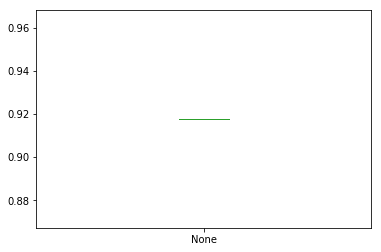

In [120]:
test_mean_revenue.plot(kind ='box')

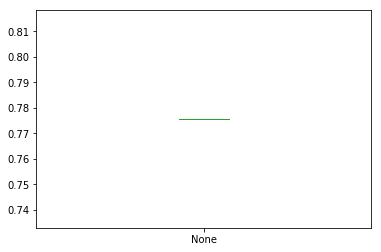

In [121]:
control_mean_revenue.plot(kind ='box')

In [122]:
test_mean_revenue.quantile([0.025, 0.975])

0.025    0.917673
0.975    0.917673
dtype: float64

In [123]:
control_mean_revenue.quantile([0.025, 0.975])

0.025    0.775555
0.975    0.775555
dtype: float64

Without doing a statistical test, we could be certain that **there is a difference between the test group and control group.** 

## summary

If we implement the new price, there is going to be an increase in the total revenue but a decrease in total number of users. 

